# Create initial conditions (3d) for temperature, salinity and layer thicknesses
- These are dependent on vertical coordinates

In [7]:
clear
homedir = getenv('HOME');
workdir = getenv('WORK');
scradir = getenv('SCRATCH');
addpath(genpath([homedir '/work_MOM']));
addpath(genpath([homedir '/mytoolbox']));
addpath(genpath([homedir '/MyFuncs']));

In [8]:
% delda_m = 200; % m
% [nih,njh] = deal(100,50); %2000x1000
% xlim = [0 delda_m*nih/1e3]; % km
% ylim = [0 delda_m*njh/1e3];
delda_m = 2000; % [m] grid spacing
xlim = [0 400]; % km
ylim = [0 200];
[nih, njh] = deal((xlim(2)-xlim(1))*1e3/delda_m, (ylim(2)-ylim(1))*1e3/delda_m);
grid = build_grid_MOM(nih,njh,xlim,ylim);

% 
dz_fnm = [homedir '/work_mlmodel/hycom1_30.nc'];
ds_dz = ncstruct(dz_fnm);
nk = length(ds_dz.dz);
% layer lower interface depth [m], nk-1
interface = [0; cumsum(ds_dz.dz)]; % interface depth [m]
zl = (interface(1:end-1) + interface(2:end))*.5; % layer center depth [m]
ztop = interface(1:end-1); % layer top depth [m]
zl';
ztop;

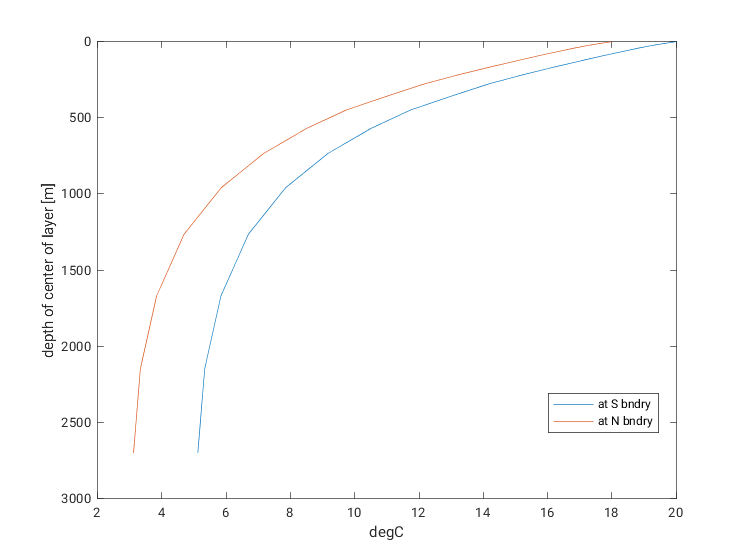

In [9]:
% vertical profiles (linear)
s_1d = linspace(35, 35, nk);

% perturbation fields (I am not sure if it's needed)
perturbation = rand(nih,njh,nk) * 1e-6;

%-------- 3d initial fields
%---- for salinity, uniform in accross a layer
s_input = repmat(reshape(s_1d,[1 1 nk]), [nih njh 1]); % + perturbation?

%---- for temperature
d = 500; % depth of thermocline [m]
[Ts_top, Ts_bot] = deal(20, 5); % temp [degC] at the top and bottom in the southern boundary
[Tn_top, Tn_bot] = deal(18, 3); % temp at the top and bottom in the northern boundary
Ts_z = Ts_top*exp(-ztop/d) + Ts_bot*(1 - exp(-ztop/d)); % vertical temp profile at southern boundary, 1d
Tn_z = Tn_top*exp(-ztop/d) + Tn_bot*(1 - exp(-ztop/d)); % vertical temp profile at southern boundary, 1d
% vary in y, linearly decreasing
t_input = 0*s_input;
Ly_p = grid.geolat(1,end) - grid.geolat(1,1);
for ik = 1:nk
   t_input(:,:,ik) = Ts_z(ik)*(grid.geolat(:,end) - grid.geolat)/Ly_p + Tn_z(ik)*(grid.geolat-grid.geolat(:,1))/Ly_p;
end

figure
plot(Ts_z,zl)
hold on
plot(Tn_z,zl)
set(gca, 'YDir','reverse')
xlabel('degC')
ylabel('depth of center of layer [m]')
legend('at S bndry','at N bndry','location','best')

% ----  initial density reconstructed from the linear EOS, just check
RHO_T0_S0 = 1000;
DRHO_DT = -0.2;
density_recons = RHO_T0_S0 + DRHO_DT .* t_input;

set(gcf,'PaperPositionMode','auto');
exportgraphics(gcf,'figures/vert_T_IC.png','ContentType','image',...
    'Resolution',600)

  Name           Size                  Bytes  Class     Attributes

  t_input      200x100x30            4800000  double              



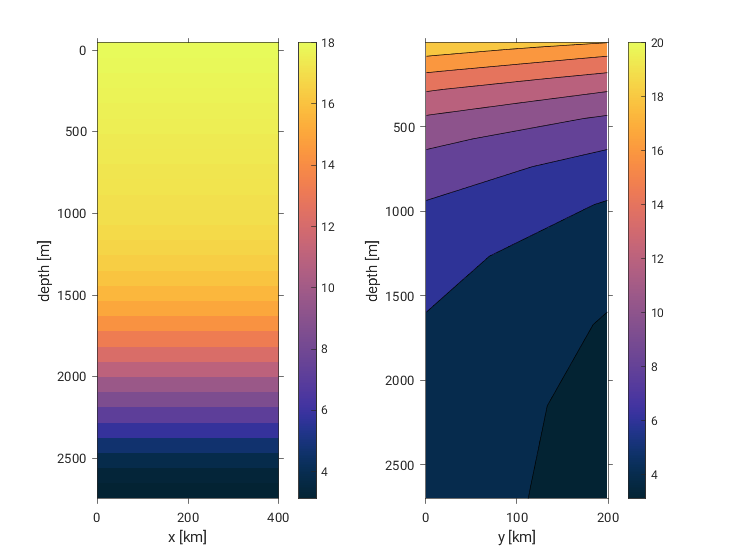

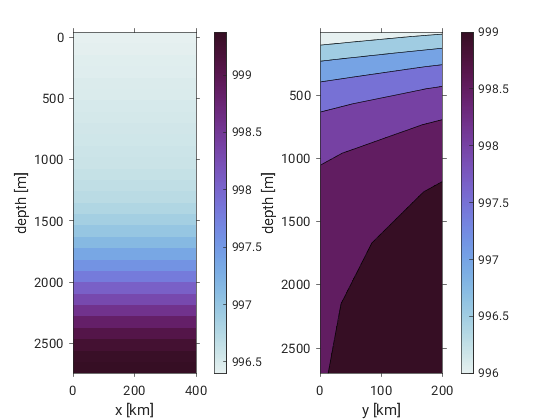

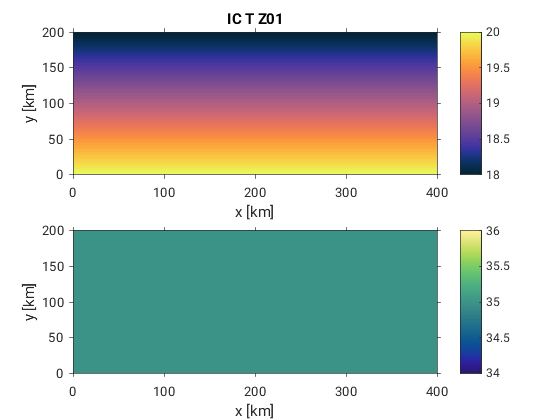

In [13]:

ii = 22;
jj = grid.njh;

figure
subplot(121)
f_do = squeeze(t_input(:,jj,:));
imagescn(grid.lonh, zl, f_do'); 
set(gca,'tickdir','out','xlim',grid.lonq([1 end]));
cmocean('thermal'); colorbar;
xlabel('x [km]')
ylabel('depth [m]')
set(gca, 'YDir','reverse')

subplot(122)
f_do = squeeze(t_input(ii,:,:));
% imagescn(grid.lath, zl, f_do'); 
contourf(grid.lath, zl, f_do'); 
set(gca,'tickdir','out','xlim',grid.latq([1 end]));
cmocean('thermal'); colorbar;
xlabel('y [km]')
ylabel('depth [m]')
set(gca, 'YDir','reverse')
set(gcf,'PaperPositionMode','auto');
exportgraphics(gcf,'figures/T_IC_vertsection.png','ContentType','image',...
    'Resolution',600)
    
figure
subplot(121)
f_do = squeeze(density_recons(:,jj,:));
imagescn(grid.lonh, zl, f_do'); 
set(gca,'tickdir','out','xlim',grid.lonq([1 end]));
cmocean('density'); colorbar;
xlabel('x [km]')
ylabel('depth [m]')
set(gca, 'YDir','reverse')
subplot(122)
f_do = squeeze(density_recons(ii,:,:));
contourf(grid.lath, zl, f_do'); 
set(gca,'tickdir','out','xlim',grid.latq([1 end]));
cmocean('density'); colorbar;
xlabel('y [km]')
ylabel('depth [m]')
set(gca, 'YDir','reverse')

figure
subplot(211)
f_do = squeeze(t_input(:,:,1));
imagescn(grid.lonh, grid.lath, f_do'); 
set(gca,'tickdir','out','xlim',grid.lonq([1 end]));
cmocean('thermal'); colorbar;
xlabel('x [km]')
ylabel('y [km]')
title('IC T Z01')
subplot(212)
f_do = squeeze(s_input(:,:,1));
imagescn(grid.lonh, grid.lath, f_do'); 
set(gca,'tickdir','out','xlim',grid.lonq([1 end]));
cmocean('haline'); colorbar;
xlabel('x [km]')
ylabel('y [km]')
exportgraphics(gcf,'figures/T_IC_xy.png','ContentType','image',...
    'Resolution',600)
% figure
% plot(zl,squeeze(t_input(22,jj,:)),'o');
whos t_input


## save

In [14]:
[xh,yh] = deal(grid.lonh, grid.lath);

savefnm = 'INPUT_2km_x400kmy200km/IC_TS.nc';
fillvalue = -1e34;

% 
nccreate(savefnm, 'xh','Format','netcdf4','Datatype','double',...
    'Dimensions',{'xh',nih});
nccreate(savefnm, 'yh','Format','netcdf4','Datatype','double',...
    'Dimensions',{'yh',njh});
nccreate(savefnm, 'zl','Format','netcdf4','Datatype','double',...
    'Dimensions',{'zl',nk});
% 
nccreate(savefnm, 'PTEMP','Format','netcdf4','Datatype','double',...
    'Dimensions',{'xh',nih,'yh',njh,'zl',nk,'Time',1},...
    'FillValue',fillvalue);
nccreate(savefnm, 'SALT','Format','netcdf4','Datatype','double',...
    'Dimensions',{'xh',nih,'yh',njh,'zl',nk,'Time',1},...
    'FillValue',fillvalue);
% 
ncwrite(savefnm,'xh',xh);
ncwrite(savefnm,'yh',yh);
ncwrite(savefnm,'zl',zl);
ncwrite(savefnm,'PTEMP',t_input);
ncwrite(savefnm,'SALT',s_input);
        
% ncbuild(savefnm, xh, 'dimnames', {'xh'}, ...
%     'varatts', {'long_name', 'longitude at cell centers', 'units', 'km'});
% ncbuild(savefnm, yh, 'dimnames', {'yh'}, ...
%     'varatts', {'long_name', 'latitude at cell centers', 'units', 'km'});
% ncbuild(savefnm, zl, 'dimnames', {'zl'}, ...
%     'varatts', {'long_name', 'layer depth (center)', 'units', 'meter'});
% ncbuild(savefnm, 1, 'name', 'Time', 'dimnames', {'Time'}, 'unlimited', {'Time'} );
% ncbuild(savefnm, t_input, 'name', 'PTEMP', 'dimnames', {'xh','yh','zl','Time'}, ...
%     'varatts', {'long_name', 'Initial potential temperature referenced to 0dbar', 'units', 'Celsius'});
% ncbuild(savefnm, s_input, 'name', 'SALT', 'dimnames', {'xh','yh','zl','Time'}, ...
%     'varatts', {'long_name', 'Initial salinity', 'units', 'PSU'});

ncdisp(savefnm)

Source:
           /glade/u/home/yueyanglu/work_mlmodel/INPUT_2km_x400kmy200km/IC_TS.nc
Format:
           netcdf4
Dimensions:
           xh   = 200
           yh   = 100
           zl   = 30
           Time = 1
Variables:
    xh   
           Size:       200x1
           Dimensions: xh
           Datatype:   double
    yh   
           Size:       100x1
           Dimensions: yh
           Datatype:   double
    zl   
           Size:       30x1
           Dimensions: zl
           Datatype:   double
    PTEMP
           Size:       200x100x30x1
           Dimensions: xh,yh,zl,Time
           Datatype:   double
           Attributes:
                       _FillValue = -9.999999999999999e+33
    SALT 
           Size:       200x100x30x1
           Dimensions: xh,yh,zl,Time
           Datatype:   double
           Attributes:
                       _FillValue = -9.999999999999999e+33


In [72]:
 max(t_input(:))


ans =

    0.0500

